# Russian House Price Regression

**Author: Jiashen Liu, Data Scientist at [Quantillion](http://quantillion.io/)** 

# 0. Intro and Fire up

This kernel can be splited into three main parts: Part A: Exploratory Data Analysis. Part B: Regressor tested and fit. Part C: Conclusion and Insight. Before we get started, we need to fire up necessary packages and load the data set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ggplot import *
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import math

After loading the data, we split the training set into two parts, as regression is a part of target, we do not do the EDA part with the whole training set as it will be cheating.

In [2]:
train = pd.read_csv('train.csv')
print(train.shape)

(30471, 292)


In [3]:
outtest = pd.read_csv('test.csv')
print(outtest.shape)
macro = pd.read_csv('macro.csv')
print(macro.shape)

(7662, 291)
(2484, 100)


**Now we got a training set with 30471 samples. We will split it with the ratio of 7:3 for EDA and training.**

In [4]:
intrain,intest = train_test_split(train,test_size = 0.3,random_state = 42)
intrain = intrain.reset_index(drop=True)
intest = intest.reset_index(drop=True)

**Reserve timestamp here**

In [5]:
intrain_time = intrain['timestamp']
intest_time = intest['timestamp']

We are gonna use data set: intrain, for the subsequent processes.

# 1. Feature Engineering

## 1.1 Price VS House Properties.

We first, have a look into the features provided in the training set. As a starting point, the label itself will be researched.

**Question 1: Is target variable normally distributed?**

In [6]:
import statsmodels.api as sm

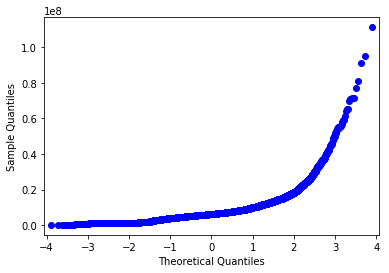

In [7]:
Label_intrain = intrain['price_doc']
fig1 = sm.qqplot(Label_intrain)
plt.show(fig1)

We can see that the normalization of original label is not quite good!

QQ Plot of Logrithm Transformation


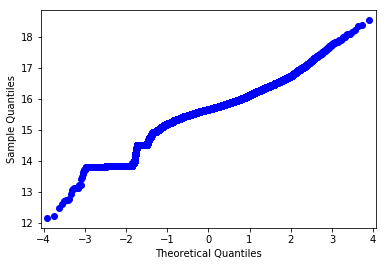

QQ Plot of Squared Transformation


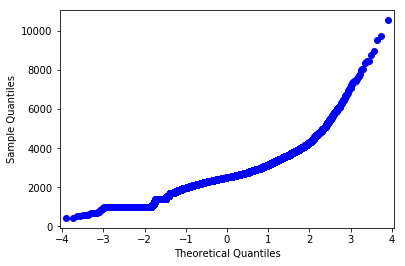

QQ Plot of Powered Transformation


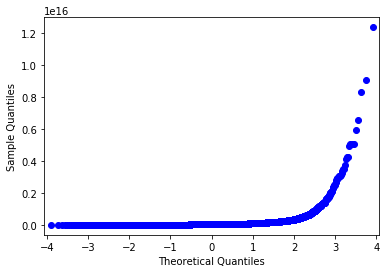

In [8]:
log_lable = np.log(Label_intrain);sq_label = np.sqrt(Label_intrain);power_label = np.power(Label_intrain,2)
fig2 = sm.qqplot(log_lable)
print('QQ Plot of Logrithm Transformation')
plt.show(fig2)
fig3 = sm.qqplot(sq_label)
print('QQ Plot of Squared Transformation')
plt.show(fig3)
fig4 = sm.qqplot(power_label)
print('QQ Plot of Powered Transformation')
plt.show(fig4)

It seems that the squared label shows a better shape in QQ plot. Seems that **Powered and Log** transformations may lead to a label that makes more sense. We will use log one instead of the original one for the following jobs.

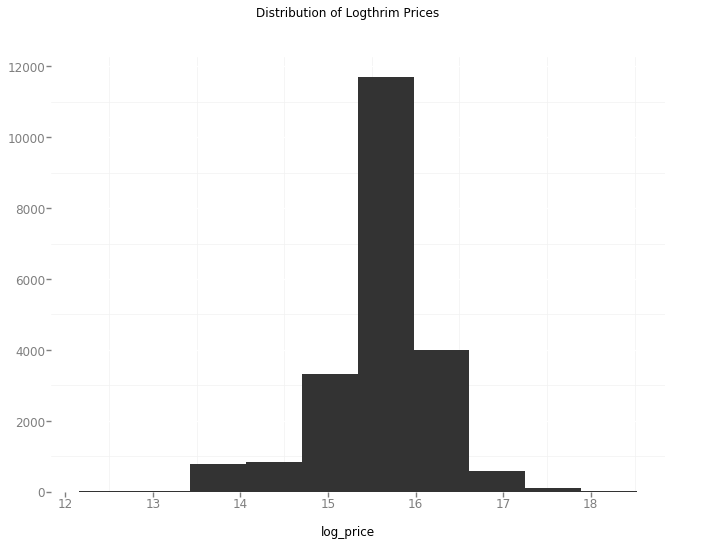

<ggplot: (8768781506119)>


In [9]:
intrain['log_price'] = log_lable
hist_log_price = ggplot(intrain,aes(x='log_price'))+geom_histogram()+theme_bw()+ggtitle('Distribution of Logthrim Prices')
print(hist_log_price)

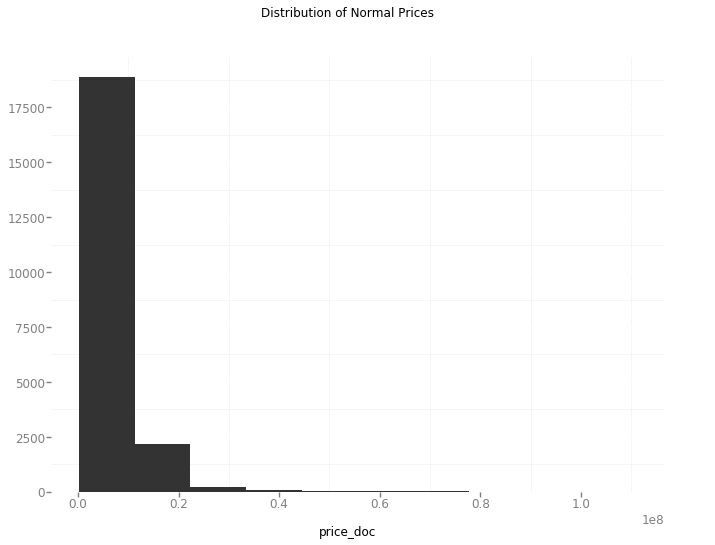

<ggplot: (8768781415414)>


In [10]:
hist_price = ggplot(intrain,aes(x='price_doc'))+geom_histogram()+theme_bw()+ggtitle('Distribution of Normal Prices')
print(hist_price)

We can see that, the log price is closer to a standard normal distribution. Therefore, we take the transformation for a better EDA and regression analysis.

Before move on, we get continous and categorical variables out of the feature group.

In [11]:
columns = list(intrain.columns)
cat = ['ID_railroad_terminal','ID_metro','timestamp','state','product_type','sub_area','culture_objects_top_25','thermal_power_plant_raion','incineration_raion','oil_chemistry_raion','radiation_raion','railroad_terminal_raion','big_market_raion','nuclear_reactor_raion','detention_facility_raion','water_1line','big_road1_1line','railroad_1line','ID_bus_terminal','ID_railroad_station_avto','ID_railroad_station_walk','ecology']
con = [each for each in columns if each not in cat]

In [12]:
con.remove('id')
con.remove('price_doc')
con.remove('log_price')

**Question 2: How many NA in each feature and which features have ignorable variance?**

In [13]:
NA_Count = pd.DataFrame({'Sum of NA':intrain.isnull().sum()}).sort(['Sum of NA'],ascending=[0])
NA_Count['Percentage'] = NA_Count['Sum of NA']/intrain.shape[1]

In [14]:
Column_to_clean = NA_Count[NA_Count['Percentage']>0].index.tolist()

We can find that, for several columns with NA values, they share the **same** counts. So the NA values probably appears in group. If we check the names of those columns, we can find that appearing in groups are not strange. For example, bed_count_ are one possible example. Same as quota.

In order to correctly deal with those NA values, I want to compare the distribution of log-price of samples which have NA values in a specific columns and the others with no NA and to see whether 'NA' causes obvious effects in transformed prices.

In [15]:
def dist_comparison(column_name):
    tmp = intrain
    lis = intrain[column_name]
    trans = ['Missing Value' if math.isnan(each) else 'Not_Missing' for each in lis]
    tmp['NA_Signal'] = trans
    g = ggplot(tmp,aes(x = 'log_price')) + geom_histogram()+facet_wrap('NA_Signal')+theme_bw()+ggtitle('Comparision of log-prices for Missing and Non-missing in column '+column_name)
    return print(g)

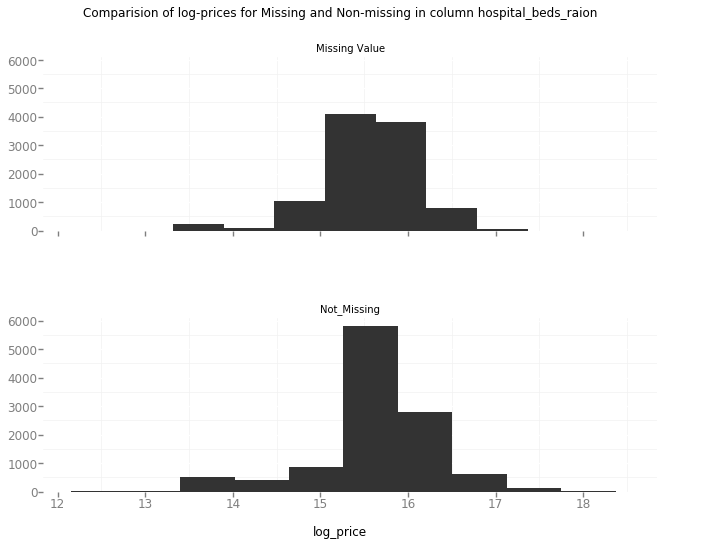

<ggplot: (-9223363268073431082)>


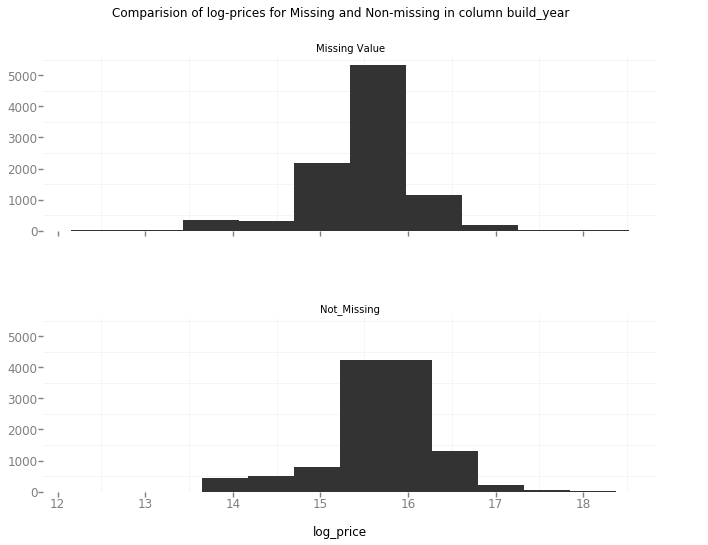

<ggplot: (8768781372757)>


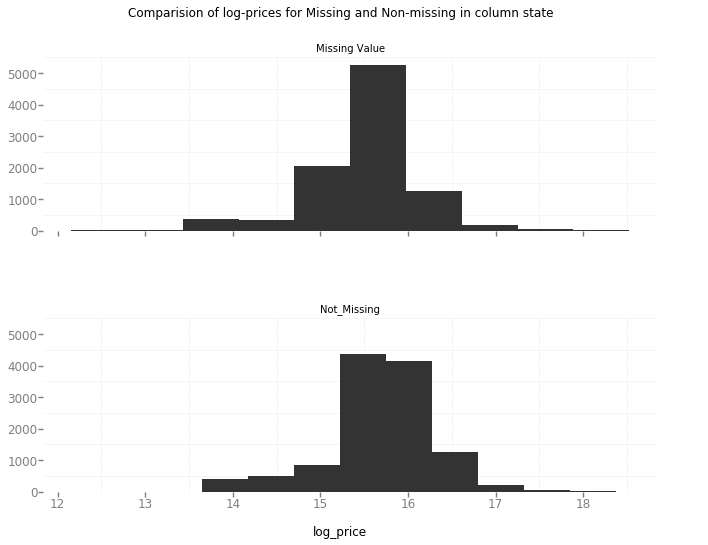

<ggplot: (8768781220451)>


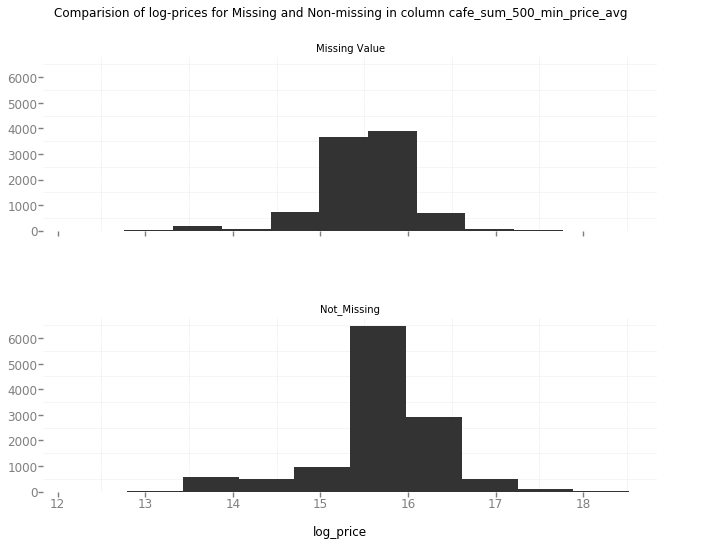

<ggplot: (-9223363268073597219)>


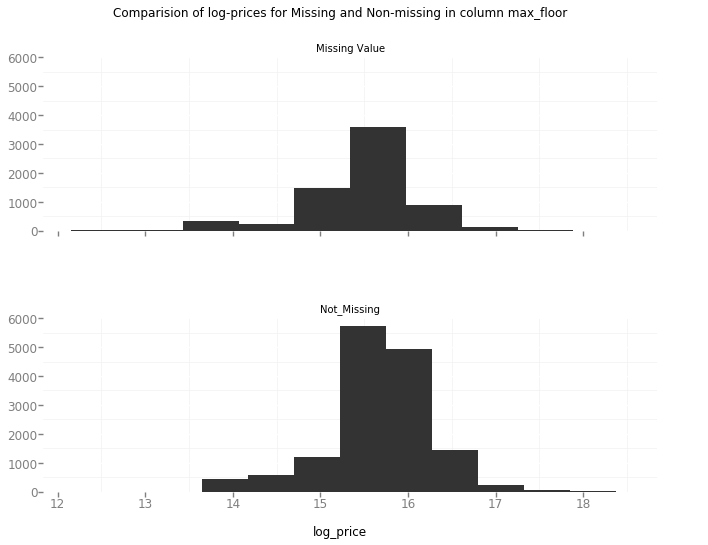

<ggplot: (-9223363268073688881)>


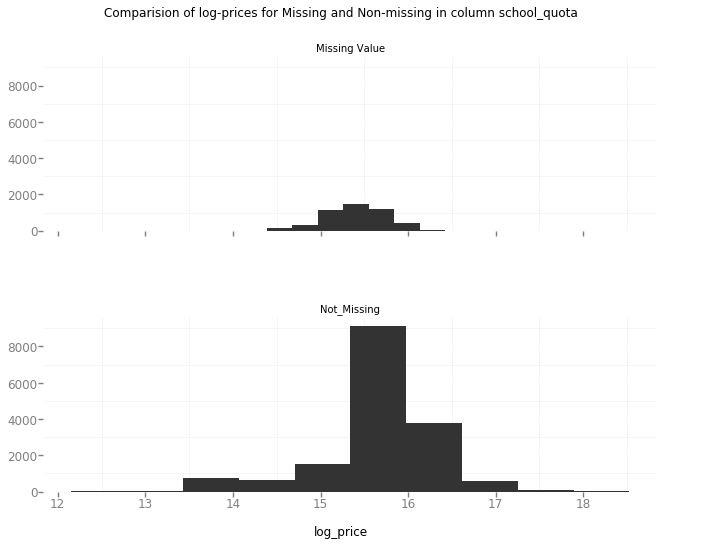

<ggplot: (-9223363268073755830)>


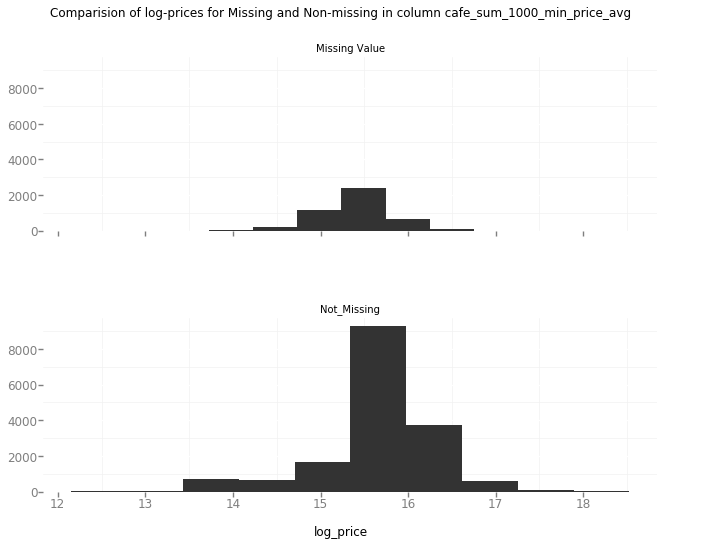

<ggplot: (8768781350313)>


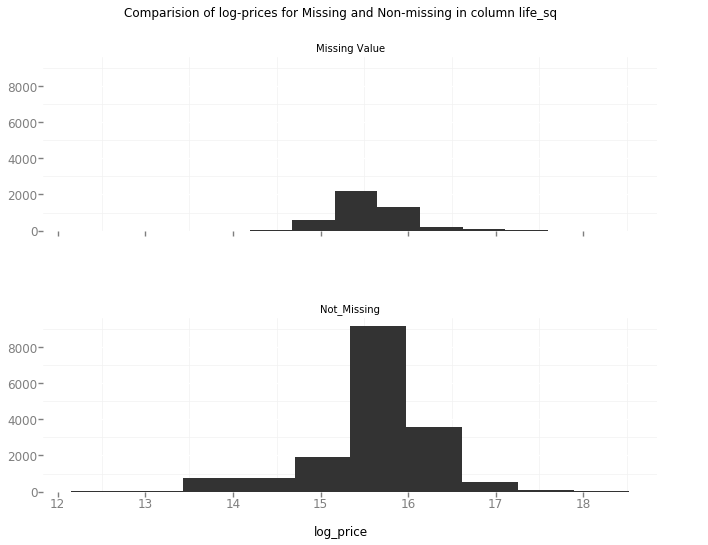

<ggplot: (-9223363268073431201)>


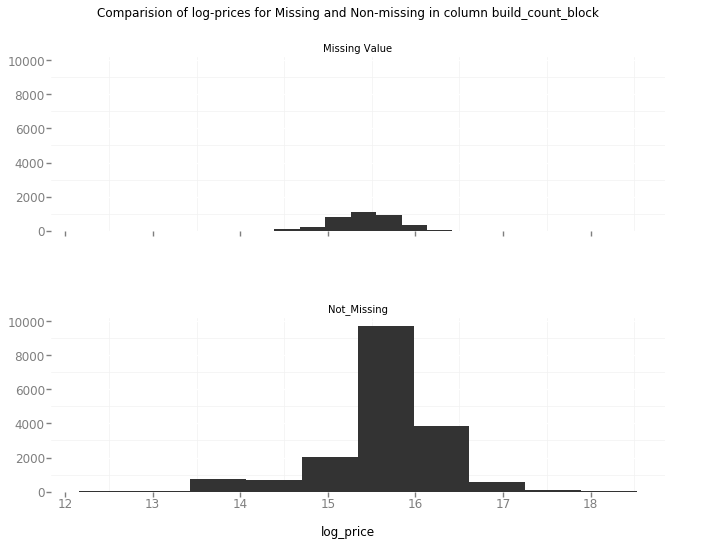

<ggplot: (-9223363268073526833)>


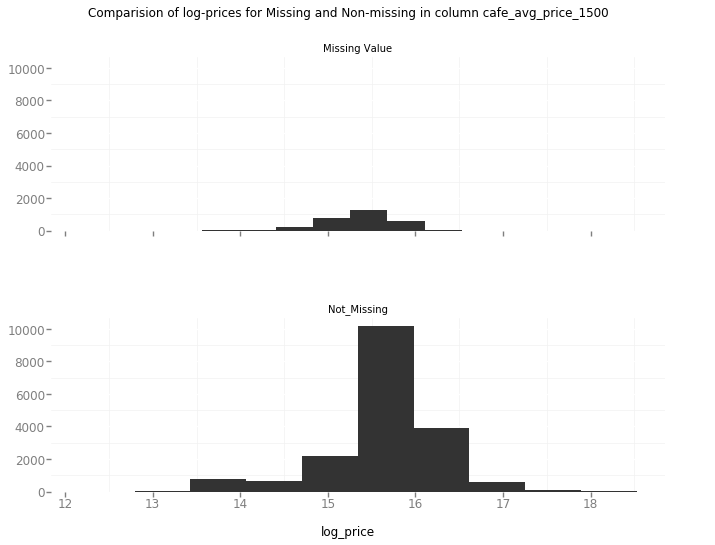

<ggplot: (-9223363268073677259)>


In [16]:
NA_Columns = ['hospital_beds_raion','build_year','state','cafe_sum_500_min_price_avg','max_floor','school_quota','cafe_sum_1000_min_price_avg','life_sq','build_count_block','cafe_avg_price_1500']
for each in NA_Columns:
    dist_comparison(each)

So, we need to deal with the missing values before move on. The general principle is as following: for the categorical variables: we just fill them with -999. For the continous variables that do not have many missing values, we just fill them with 0. For the others: since many of them have different shapes on log-price distribution in comparison with the non-missing values, we take the median values of the rest to fill the Nan.

In [17]:
def fill_na():
    Special_Filling = ['hospital_beds_raion','build_year','cafe_sum_500_min_price_avg','max_floor']
    for each in Column_to_clean:
        if each in cat:
            fill_value = -999
        elif each in Special_Filling:
            fill_value = np.median(list(intrain[each].dropna()))
        else:
            fill_value = 0
        intrain[each]=intrain[each].fillna(fill_value)
        intest[each]=intest[each].fillna(fill_value)
        outtest[each]=outtest[each].fillna(fill_value)

In [18]:
fill_na()

Then we have finished the process of filling NA. I am not sure whether this is the best way of doing this, but seems with an overwhelming amount of independent features, we are not possible to go through them one by one.

**Question 3: Do we need to do one-hot-encoding for categorical variables?**

Definitely a 'yes'. We need to do it before fit the models! In order to call the preprocess functions in sklearn, we define a function that can get the indexes of certain columns here.

In [26]:
def get_index(df,cols):
    return [df.columns.get_loc(each) for each in cols]

We just keep it here. 

**Question 4: Which continous variables are more correlated with the price?**

We will check the correlation between the log-price and each continous variables in this part of kernel.

In [27]:
Var = []
Cor = []
for each in con:
    cor = np.absolute(np.corrcoef(intrain[each],intrain['log_price'])[0][1])
    Var.append(each)
    Cor.append(cor)
Cor_target_var = pd.DataFrame({'Var':Var,'Cors':Cor}).sort(['Cors'],ascending=0).reset_index(drop=True)

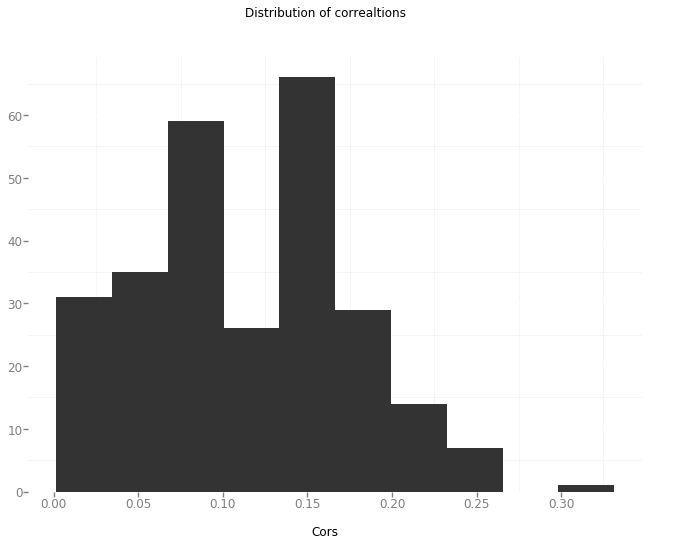

<ggplot: (8768780928667)>


In [28]:
g = ggplot(Cor_target_var,aes(x='Cors'))+geom_histogram()+ggtitle('Distribution of correaltions')+theme_bw()
print(g)

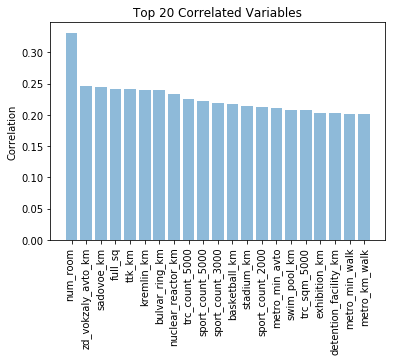

In [29]:
Top_20 = Cor_target_var.ix[0:20,:]
Least_20 = Cor_target_var.ix[250:269,:]
pos_1 = np.arange(len(Top_20))
plt.bar(pos_1, Top_20['Cors'], align='center', alpha=0.5)
plt.xticks(pos_1, Top_20['Var'],rotation='vertical')
plt.ylabel('Correlation')
plt.title('Top 20 Correlated Variables') 
plt.show()

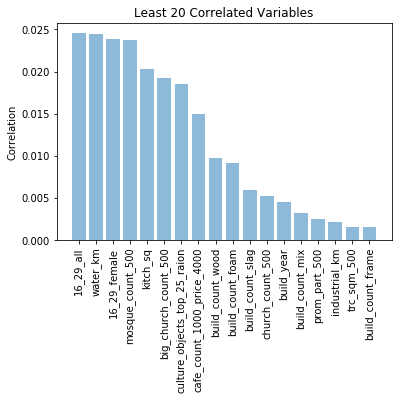

In [30]:
pos_2 = np.arange(len(Least_20))
plt.bar(pos_2, Least_20['Cors'], align='center', alpha=0.5)
plt.xticks(pos_2, Least_20['Var'],rotation='vertical')
plt.ylabel('Correlation')
plt.title('Least 20 Correlated Variables') 
plt.show()

If you are interested, you can draw some simple scatter plots to verify the above conclusion.

For detecting the multicolinearity, we also prepare another variable set here.

**Question 5: whether there are multicolinearity existing among variables?**

In [31]:
con_variables = intrain[con]
con_variables_matrix = con_variables.as_matrix()

In [32]:
correlation_matrix = np.corrcoef(con_variables_matrix.T)

We first, check the average correlation for each individual variable among the others.

In [33]:
Vars = []
Cors = []
for i in range(correlation_matrix.shape[0]):
    var = con[i]
    avg_cor = np.mean(list(np.fabs(correlation_matrix[i]))) # Take the absolute values.
    Vars.append(var)
    Cors.append(avg_cor)
Average_Cor = pd.DataFrame({'Vars':Vars,'Cors':Cors}).sort(['Cors'],ascending=0)

In [34]:
Average_Cor.head()

,Cors,Vars
243,0.452328,sport_count_3000
226,0.451269,trc_count_3000
220,0.445641,sport_count_2000
249,0.445506,trc_count_5000
266,0.444727,sport_count_5000


The average correlations are reasonable enough. The next step, we will check the specific correlation between pairs of variables in the training set. Base on [this answer]('https://stats.stackexchange.com/questions/100175/when-can-we-speak-of-collinearity'), rule of thumb for multicolinearity is 0.95, regarding pearson correlation.

In [35]:
def multicol_vars(threshold=0.95):
    List= []
    columns = list(con_variables)
    leng = con_variables.shape[1]
    for i in range(leng):
        for j in range(leng):
            if np.absolute(correlation_matrix[i][j])>threshold and np.absolute(correlation_matrix[i][j])<0.999999:
                column_list = sorted([columns[i],columns[j]])
                sig_dic = {'Var1':column_list[0],'Var2':column_list[1],'Cor':correlation_matrix[i][j]}
                List.append(sig_dic)
    Var1 = []
    Var2 = []
    Cor = []
    for i in range(len(List)):
        Var1.append(List[i]['Var1'])
        Var2.append(List[i]['Var2'])
        Cor.append(List[i]['Cor'])
    df = pd.DataFrame({'Var1':Var1,'Var2':Var2,'Cor':Cor})
    output = df.drop_duplicates(['Var1','Var2'])
    return output

In [38]:
Multi_col = multicol_vars(0.95)

In [37]:
Multi_col=Multi_col.reset_index(drop=True)

The first impression for this number is quite shocking. However, if we have a look into the data set, we can find that, many variables should be redundunt. For example: Number of gyms within 3km and 5km. We will use the questions of question 3 and 4 to choose the features in this data set.

**Question 6: Which continous variable should we keep for the regression?**

Now we have known: which varables are more correlated with the log-price, and among which variables the correlations are big enough to create the potential multicolinearity. After that, we are able to finish the feature selection process by the results of above analysis. 

The general principle of it is: for two variables that have high correlation: we choose the one with higher correlation with the target variable.

In [41]:
Bigger_Var = []
Smaller_Var = []
columns = list(con_variables)
leng = len(columns)
for i in range(leng):
    for j in range(leng):
        Var1 = columns[i]
        Var2 = columns[j]
        i_cor_t = list(Cor_target_var[Cor_target_var['Var']==Var1]['Cors'])[0]
        j_cor_t = list(Cor_target_var[Cor_target_var['Var']==Var2]['Cors'])[0]
        if np.absolute(correlation_matrix[i][j])>0.95 and np.absolute(correlation_matrix[i][j])<0.999999:
            if np.absolute(i_cor_t)>=np.absolute(j_cor_t):
                Bigger_Var.append(Var1)
                Smaller_Var.append(Var2)

For those variables that show multicolinearity with the others but **never** have a larger correlation with the target variables, we think that they need to be abondoned since they may cause overfitting in the regression.

In [42]:
Bigger_Var = list(set(Bigger_Var))
Smaller_Var = list(set(Smaller_Var))

For those variables that never show up in the list of 'Smaller Correlation Variables', we choose to keep them. The others will be abondoned.

In [43]:
Kept_Var =[each for each in Bigger_Var if each not in Smaller_Var]

In [44]:
Kept_Var

['raion_build_count_with_material_info',
 'cafe_sum_3000_max_price_avg',
 'big_church_count_1000',
 'sport_count_5000',
 'railroad_station_avto_km',
 'metro_km_walk',
 'cafe_sum_500_max_price_avg',
 'school_education_centers_raion',
 'school_quota',
 'cafe_sum_1000_max_price_avg',
 'cafe_count_3000_price_high',
 'cafe_sum_1500_max_price_avg',
 'ekder_male',
 'cafe_count_1500_price_high',
 'office_count_1000',
 'male_f',
 'school_km',
 'zd_vokzaly_avto_km',
 'office_sqm_5000',
 'cafe_sum_5000_max_price_avg',
 'cafe_sum_2000_max_price_avg',
 'cafe_count_500_price_1500',
 'cafe_count_3000_price_1000',
 'metro_min_walk']

In [45]:
Abondon_Var_A = [each for each in Bigger_Var if each not in Kept_Var]
Abondon_Var_B = [each for each in Smaller_Var if each not in Kept_Var]
Abondon_Var = list(set(Abondon_Var_A + Abondon_Var_B))

With the other list comprehension, we can finishe the manual feature selection for continous variables.

In [46]:
con_var_selected = [each for each in columns if each not in Abondon_Var]

In [47]:
print(len(con_var_selected))

157


With the categorical variables in the data set, we can have the final variable list for the regression.

In [49]:
variable_1 = con_var_selected +cat

## 1.2 Price VS Macro Data.

We also got time stamp in the feature list for the data. However, simply including the timestamp in the regression model may not be a good idea, since time itself cannot change anything related to the house price. Instead, the economy associated with the time may be the force behind house prices.

We first see how many empty values in each column of Macro dataset.

**Question 1: How can we deal with the missing values?**

In [53]:
NA_Count_Macro = pd.DataFrame({'Sum of NA':macro.isnull().sum()}).sort(['Sum of NA'],ascending=[0])

In [54]:
NA_Count_Macro['Percentage']=NA_Count_Macro['Sum of NA']/macro.shape[0]

In [55]:
NA_Count_Macro.head()

,Sum of NA,Percentage
provision_retail_space_modern_sqm,1754,0.706119
provision_retail_space_sqm,1753,0.705717
modern_education_share,1389,0.559179
old_education_build_share,1389,0.559179
hospital_beds_available_per_cap,1023,0.411836


Many macro economy data is definitely missing! Since all variables (at least from my point of view) are continous, for the variables have more than 60% of missing value, I choose to drop them.

In [56]:
NA_Count_Macro = NA_Count_Macro[NA_Count_Macro['Percentage']>0]
NA_Count_Macro = NA_Count_Macro[NA_Count_Macro['Percentage']<0.4]

Other variables also contain numerous missing data, if I go through them one by one it may be quite time consuming. Instead, I choose to deal with them in batch. Filling the empty cell by the median of column is my choice.

In [57]:
Macro_Vars = NA_Count_Macro.index.tolist()

In [58]:
for i in range(macro.shape[0]):
    for j in range(1,macro.shape[1]):
        try:
            macro.ix[i,j] = macro.ix[i,j].replace(',','')
        except Exception:
            pass

**This annoying problem of ',' is dealt in a really robust way.**

In [60]:
F

In [61]:
for each in Macro_Vars:
    macro[each] = list(np.array(macro[each]).astype(np.float))

In [62]:
def fill_na_macro():
    for each in Macro_Vars:
        #print(each)
        Drop_NA = list(macro[each].dropna())
        try:
            Drop_NA = list(np.array(Drop_NA).astype(np.float))
        except Exception:
            macro[each] = macro[each].replace('#!',None)
        filled_value = np.median(Drop_NA) 
        macro[each] = macro[each].replace()
        macro[each]=macro[each].fillna(filled_value)

In [63]:
fill_na_macro()

In [64]:
vars_macro= ['timestamp']+Macro_Vars
macro_final = macro[vars_macro]

With two extra steps of data cleansing, we finally get the data we want for macro.

**Quesion 2: What is the pure time series of House price and Log House Price?**

Before we further choose the features we are gonna use, we first check: the price trend vs time for the properties.

Timestamp in the original intrain data set has been changed. We need to change them back. 

In [65]:
intrain['timestamp'] = intrain_time
intest['timestamp'] = intest_time

In [66]:
Mergered_intrain = intrain.merge(macro_final,on = 'timestamp',how='left')
Mergered_intest = intest.merge(macro_final,on = 'timestamp',how='left')

In [67]:
Mergered_intrain.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,ppi,balance_trade,deposits_growth,micex,rts,micex_rgbi_tr,usdrub,brent,eurrub,micex_cbi_tr
0,14068,2014-01-24,46,44.0,7.0,25.0,1.0,2015.0,1.0,1.0,...,485.5,20.182,0.042848,1494.58,1364.11,132.26,34.5518,107.88,47.2639,244.71
1,12981,2013-12-11,77,48.0,17.0,17.0,4.0,2009.0,3.0,9.0,...,480.6,20.191,0.012373,1464.67,1409.28,133.41,32.7607,109.70,45.1999,241.54
2,18698,2014-05-21,39,18.0,7.0,17.0,1.0,1979.0,1.0,9.0,...,500.3,21.583,0.017123,1439.90,1317.09,126.73,34.3860,110.55,46.9807,244.85
3,26414,2014-12-15,52,52.0,9.0,17.0,1.0,0.0,2.0,1.0,...,510.1,15.317,0.022713,1424.99,718.32,107.43,64.2372,61.06,80.0946,242.15
4,1422,2012-03-05,30,18.0,1.0,12.0,0.0,1979.0,0.0,0.0,...,449.0,20.858,0.013314,1625.74,1752.17,131.88,29.3422,123.80,38.8094,213.22


We take the average value on each stamp for two prices variables in order to finish the time series plots.

In [68]:
Price_time = Mergered_intrain.groupby(['timestamp'],as_index=False)['price_doc','log_price'].mean()

In [69]:
Price_time['timestamp'] = pd.to_datetime(Price_time['timestamp'])

Plot time vs prices

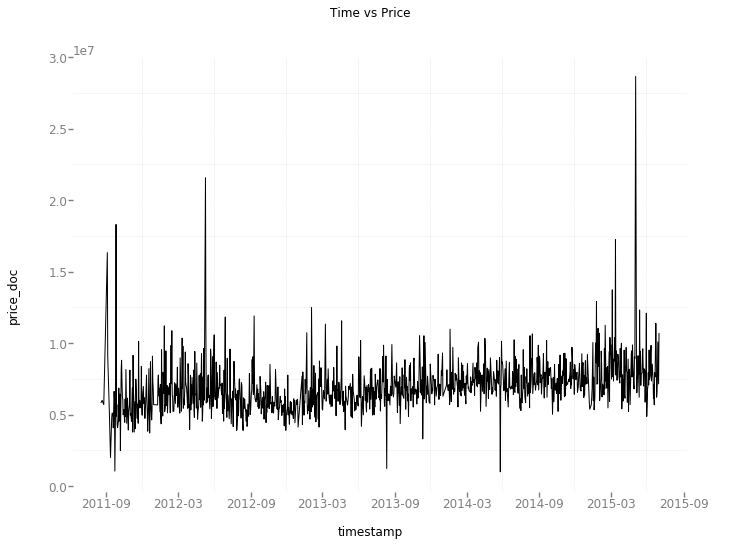

<ggplot: (8768780971198)>


In [70]:
g = ggplot(Price_time,aes(x='timestamp',y='price_doc'))+geom_line()+theme_bw()+ggtitle('Time vs Price')
print(g)

Plot time vs log-price

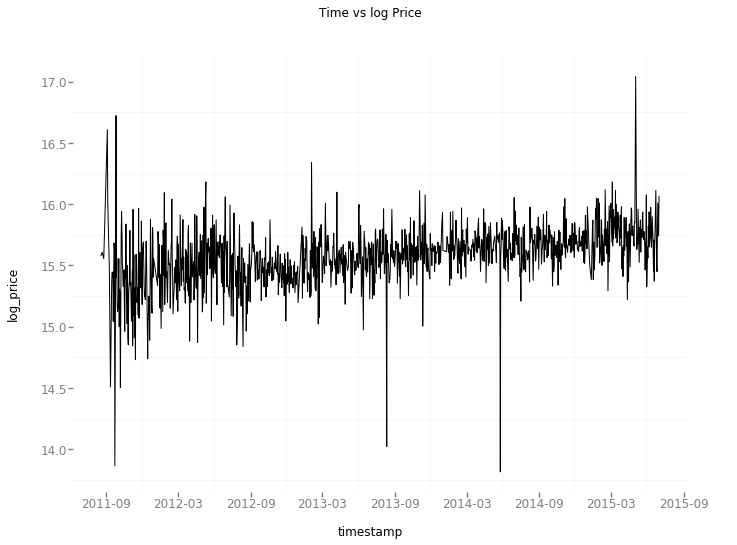

<ggplot: (8768781286590)>


In [71]:
g = ggplot(Price_time,aes(x='timestamp',y='log_price'))+geom_line()+theme_bw()+ggtitle('Time vs log Price')
print(g)

Through the log price trendline, one can see a more obvious up trend existing in the data set. However, as I said, it is not quite wise to use a pure time series for this case since a regression problem is not a time series problem only. Next, we will check: correlations between different variable and target and the potential multicolinearity among variables.

**Question 3: What are correlations between target variable (log_price) and each variable?**

In [72]:
Cors = []
Vars = []
for each in Macro_Vars:
    #print(each)
    Vars.append(each)
    Cors.append(list(np.corrcoef(Mergered_intrain['log_price'],Mergered_intrain[each]))[0][1])
Cor_Macro = pd.DataFrame({'Vars':Vars,'Cors':Cors}).sort(['Cors'],ascending=[0])

In [73]:
Cor_Macro.head()

,Cors,Vars
45,0.153306,turnover_catering_per_cap
47,0.153103,salary
27,0.151954,bandwidth_sports
37,0.151785,gdp_deflator
46,0.149094,invest_fixed_assets


We can see that variables in this data set are not as obvious as in the previous one. 

**Question 4: Multicolinearity detecting**

As many macro economy data may be correlated with each other, multicolinearity will cause problem if we do not detect and remove the dangerous variables. 

In [74]:
mac = Mergered_intrain[Macro_Vars].as_matrix()
correlation_m = np.corrcoef(mac.T)
Bigger_Var_m =[]
Smaller_Var_m = []
for i in range(len(Macro_Vars)):
    for j in range(len(Macro_Vars)):
        Var1 = Macro_Vars[i]
        Var2 = Macro_Vars[j]
        Cor1 = list(Cor_Macro[Cor_Macro['Vars']==Var1]['Cors'])[0]
        Cor2 = list(Cor_Macro[Cor_Macro['Vars']==Var2]['Cors'])[0]
        if correlation_m[i][j]>=0.95 and correlation_m[i][j]<0.9999:
            if Cor1>=Cor2:
                Bigger_Var_m.append(Var1)
                Smaller_Var_m.append(Var2)
Bigger_Var_m = list(set(Bigger_Var_m))
Smaller_Var_m = list(set(Smaller_Var_m))

In [75]:
Kept_Variable_macro = [each for each in Bigger_Var_m if each not in Smaller_Var_m]

So, we just keep the variables which a: will not cause the multicolinearity b: have greater impact on the label.

In [76]:
Final_var = [each for each in Macro_Vars if each not in Bigger_Var_m+Smaller_Var_m]
Final_var = Final_var + Kept_Variable_macro
Final_var_macro = list(set(Final_var))

In [77]:
print(len(Final_var_macro))
print(Final_var_macro)

49
['pop_natural_increase', 'child_on_acc_pre_school', 'deposits_growth', 'balance_trade', 'childbirth', 'retail_trade_turnover_growth', 'students_state_oneshift', 'rent_price_1room_bus', 'turnover_catering_per_cap', 'housing_fund_sqm', 'perinatal_mort_per_1000_cap', 'micex', 'salary_growth', 'load_of_teachers_school_per_teacher', 'sewerage_share', 'rent_price_2room_bus', 'balance_trade_growth', 'old_house_share', 'overdue_wages_per_cap', 'power_clinics', 'divorce_rate', 'electric_stove_share', 'average_provision_of_build_contract_moscow', 'rent_price_3room_bus', 'micex_rgbi_tr', 'rent_price_3room_eco', 'rent_price_4+room_bus', 'rent_price_1room_eco', 'rent_price_2room_eco', 'cpi', 'pop_total_inc', 'gdp_quart_growth', 'brent', 'real_dispos_income_per_cap_growth', 'seats_theather_rfmin_per_100000_cap', 'mortgage_growth', 'income_per_cap', 'lodging_sqm_per_cap', 'net_capital_export', 'load_on_doctors', 'gdp_quart', 'provision_doctors', 'micex_cbi_tr', 'invest_fixed_assets_phys', 'provisi

Now the variables from Macro economy are also selected with the same principle. We can start the regression progress now.

Let's put those features together!

In [78]:
Final_vars = variable_1 + Final_var_macro

In [91]:
Final_vars.remove('timestamp')

# 2. Machine Learning

Time for machine learning. I will briefly go through different model and different data set, for comparing the performance and accuracy of different regressors.

Before that, let's define the function of RMSLE based on the formula in this [blog](https://www.kaggle.com/wiki/RootMeanSquaredLogarithmicError)

In [85]:
def RMSLE(prediction,actual):
    leng = len(prediction)
    pred_add = [each+1 for each in prediction]
    actual_add = [each+1 for each in actual]
    log_pred = list(np.log(pred_add))
    log_actual = list(np.log(actual_add))
    minus = [i-j for i,j in zip(log_pred,log_actual)]
    return np.power(sum(np.power(minus,2))/leng,0.5)

We need to prepare two sets of training and testing sets containing different features.

In [88]:
Merged_intrain = intrain.merge(macro_final,on='timestamp',how='left')
Merged_intest = intest.merge(macro_final, on ='timestamp',how='left')
Merged_test = outtest.merge(macro_final, on ='timestamp',how='left')

In [97]:
Merged_intest['log_price'] = np.log(Merged_intest['price_doc'])

We put features and labels down here. 

In [158]:
Train_Label = Merged_intrain['log_price']
Test_Label = Merged_intest['log_price']
Train_Features = Merged_intrain[Final_vars]
Test_Features = Merged_intest[Final_vars]
Predictors = Merged_test[Final_vars]

We will try different regressors in certain Pipeline one by one. Training pipeline should include: One-hot encoding for cat variables, call regressor and tune hyperparameters before fit the model. In order to have more 

In [ ]:
#cat.remove('timestamp')

Here, we transform each categorical variables into numeric form.

In [166]:
for each in cat:
    Train_Features[each]=pd.factorize(Train_Features[each], sort=True)[0]
    Test_Features[each]=pd.factorize(Test_Features[each],sort=True)[0]
    Predictors[each]=pd.factorize(Predictors[each],sort=True)[0]

## 2.1: Linear Regression and Lasso/PCA/Polynominal

In [196]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

Let's just try pure Linear Regression first.

In [227]:
Model_group = []
Duration_group = []
Params_group = []
Metric_group = []

In [230]:
#Model = LinearRegression(n_jobs=-1)
Model = Pipeline([
 #('oe',OneHotEncoder(categorical_features=Array_cat)),
 ('reg',LinearRegression(n_jobs=-1))
])
Model_group.append('Linear Regression')
starting_time = time.time()
Model.fit(Train_Features,Train_Label)
Duration = time.time() - starting_time
Duration_group.append(Duration)
print('Training Time is '+str(Duration))
pred = Model.predict(Test_Features)
actual_pred = np.exp(pred)
Accuracy = RMSLE(actual_pred,np.exp(Test_Label))
Metric_group.append(Accuracy)
print('Performance of Model: '+str(Accuracy))
Params_group.append({})

Training Time is 1.3074908256530762
Performance of Model: 0.505049139814


Lasso Regression with step 2 polynomial transformation: if do it directly, it will cause Memory error. So, for the purpuse of practice, I put a PCA progress in pipeline for reducing the dimension. 

In [231]:
Model_group.append('Lasso Regression Poly 2')
pipeline =Pipeline([
    ('pca',PCA(n_components=5)),
    ('poly', PolynomialFeatures(include_bias=True)),
    ('las',Lasso())
])
poly_parameters = [2,3,4]
laso_parameters = [30,50,100,200]
#pca_parameters = [30]
cross_v = GridSearchCV(pipeline,param_grid={'poly__degree':poly_parameters,'las__alpha':laso_parameters},cv=3)
starting_time = time.time()
cross_v.fit(Train_Features,Train_Label)
Duration = time.time() - starting_time
Duration_group.append(Duration)
print('Training Time is '+str(Duration))

Training Time is 178.67547225952148


In [232]:
pred = cross_v.predict(Test_Features)
actual_pred = np.exp(pred)
Accuracy = RMSLE(actual_pred,np.exp(Test_Label))
Metric_group.append(Accuracy)
print('Performance of Model: '+str(Accuracy))
Parameters = cross_v.best_params_
print(Parameters)
Metric_group.append(Parameters)

Performance of Model: 0.57170814721
{'las__alpha': 30, 'poly__degree': 4}
